<a href="https://colab.research.google.com/github/gaurangdave/mnist_object_detection/blob/main/notebooks/03_google_colab_migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Object Detection

# Import Libraries

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.datasets import fetch_openml
from keras.datasets import mnist


import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image


In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Data Access

## Set Constants  

In [14]:
data_dir = Path("data")
models_dir = Path("models")

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Data Generation

## Bounding Box Generation

In [17]:
## helper function to plot the mnist data instances
def plot_numbers(image_df, num_of_columns = 5):
    ## lets render each image to do a quick visual inspection
    num_instances = image_df.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)
    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))
    axs = axs.ravel()
    for idx in range(0,num_instances,1):
        if(type(image_df) == np.ndarray):
            image_data = image_df[idx]
        else:
            image_data = image_df.iloc[idx].values  # MNIST images are 28x28 pixels
        # Render the image using Matplotlib
        axs[idx].imshow(image_data)  # Use 'gray' colormap to render grayscale


    plt.axis("off") # Remove axes for better visualization
    plt.show()

In [18]:
def get_random_images(dataset, size=5):
  random_indices = np.random.choice(len(dataset), size=size, replace=False)
  sample_images = dataset[random_indices]
  return sample_images


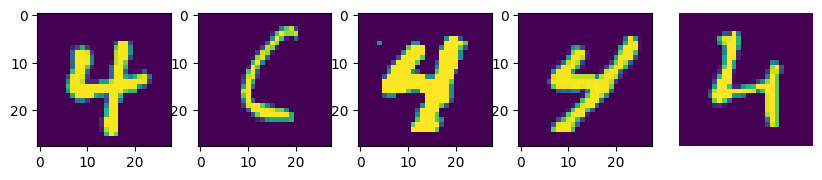

In [22]:
sample_images = get_random_images(x_train, 5)

plot_numbers(sample_images)

In [23]:
## helper function to calculate bounding box for each instance and return it.
def map_bounding_box(mnist_intance):
    padding = 1
    ## save the current class for later
    curr_class = mnist_intance["class"]

    ## extract pixel information
    pixels = mnist_intance.drop(labels=["class"])
    ## reshape the pixels
    pixels = pixels.values.reshape(28,28)

    ## calculate active rows & columns
    active_rows = np.sum(pixels,axis=1)
    active_columns = np.sum(pixels, axis=0)

    ## calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    ## add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)

    ## calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)

    ## calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1

    return pd.Series({
        "class": curr_class,
        "x_center": x_center,
        "y_center": y_center,
        "width": width,
        "height": height
    })

## Bounding Box Visualization

In [24]:
## right now we don't know how would we uses this function, for now assumption is we'll pass in 2 dataframes
## we'll revisit the function signature as we proceed with the project
from matplotlib import patches

def visualize_bounding_box(pixel_data, target_data,num_of_columns = 5):
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))
    axs = axs.ravel()

    for idx in range(0,num_instances,1):

        original = tf.constant(pixel_data.iloc[idx].values.reshape(28,28,1))
        converted = tf.image.grayscale_to_rgb(original)

        x_center = target_data.iloc[idx]["x_center"]
        y_center = target_data.iloc[idx]["y_center"]
        width = target_data.iloc[idx]["width"]
        height = target_data.iloc[idx]["height"]

        x = round(x_center - (width) / 2)
        y = round(y_center - (height) / 2)

        rect = patches.Rectangle((x,y),width=width,height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)

        axs[idx].set_title(target_data.iloc[idx]["class"])
        axs[idx].axis("off")
    plt.show()

# Training & Evaluation

# Test Data Validation